<div>
    <h1 style = "font-size: 48px; color: #008080; text-align: center;" >🦋 Butterfly Detection 🦋 </h1>
</div>

In [1]:
import pandas as pd #to import data
import os
import sys
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
from sklearn.utils import shuffle   #unsure if you need this
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import warnings 
warnings.filterwarnings('ignore')



<div>
    <h2 style = "font-size: 24px; color: #FFC0CB; text-align: center;" > Data Processing & Label Encoding  </h2>
    <h3 style = "font-size: 12px; color: #9370DB; text-aligh: center;"	> Since this was my first time using Jupyter Notebooks, I had a hard time trying to read in my data. Any time I would get close, I would cause bugs to Rachel's work. So after some research, I decided to install pandas and upload directly in my notebook</h3>

</div>

In [2]:
df_train = pd.read_csv('train/Training_set.csv')
df_test = pd.read_csv('test/Testing_set.csv')
df_train.sample(10)



,filename,label
4201,Image_4202.jpg,PEACOCK
4375,Image_4376.jpg,CLEOPATRA
3983,Image_3984.jpg,SLEEPY ORANGE
1286,Image_1287.jpg,RED SPOTTED PURPLE
399,Image_400.jpg,BLUE SPOTTED CROW
928,Image_929.jpg,SOUTHERN DOGFACE
5474,Image_5475.jpg,CLOUDED SULPHUR
4952,Image_4953.jpg,MESTRA
4280,Image_4281.jpg,DANAID EGGFLY
3463,Image_3464.jpg,GREAT JAY


In [3]:
df_test.head()

,filename
0,Image_1.jpg
1,Image_2.jpg
2,Image_3.jpg
3,Image_4.jpg
4,Image_5.jpg


In [4]:
df_train.info(), df_train.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6499 entries, 0 to 6498
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  6499 non-null   object
 1   label     6499 non-null   object
dtypes: object(2)
memory usage: 101.7+ KB


(None, (6499, 2))

In [5]:
df_test.info(), df_test.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2786 entries, 0 to 2785
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  2786 non-null   object
dtypes: object(1)
memory usage: 21.9+ KB


(None, (2786, 1))

In [6]:
df = pd.concat([df_train[['filename']], df_test[['filename']]], axis='rows')
df['label'] = [1]*len(df)
df.sample(10)

,filename,label
5334,Image_5335.jpg,1
4707,Image_4708.jpg,1
4301,Image_4302.jpg,1
3707,Image_3708.jpg,1
3083,Image_3084.jpg,1
3965,Image_3966.jpg,1
2378,Image_2379.jpg,1
4036,Image_4037.jpg,1
2655,Image_2656.jpg,1
834,Image_835.jpg,1


In [7]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df_train['label_en'] = encoder.fit_transform(df_train['label'])
df_train.sample(10)

,filename,label,label_en
1529,Image_1530.jpg,ZEBRA LONG WING,74
4090,Image_4091.jpg,ELBOWED PIERROT,29
1307,Image_1308.jpg,ATALA,5
768,Image_769.jpg,MILBERTS TORTOISESHELL,43
6294,Image_6295.jpg,SOUTHERN DOGFACE,66
2530,Image_2531.jpg,IPHICLUS SISTER,36
2192,Image_2193.jpg,YELLOW SWALLOW TAIL,73
1697,Image_1698.jpg,MOURNING CLOAK,45
3551,Image_3552.jpg,RED CRACKER,59
323,Image_324.jpg,BLUE MORPHO,10


In [8]:
non_target = []
MAIN_FILE = 'notbtterfly/'
for img in os.listdir(MAIN_FILE):
    non_target.append(img)

In [9]:
non_target[:10]

['23933.jpg',
 '20584.jpg',
 '21842.jpg',
 '22393.jpg',
 '22387.jpg',
 '20590.jpg',
 '21856.jpg',
 '23927.jpg',
 '20221.jpg',
 '22436.jpg']

In [10]:
non_target_labels = np.c_[non_target, [0]*len(non_target)]
non_df = pd.DataFrame(non_target_labels, columns=['filename', 'label'])
non_df.head()

,filename,label
0,23933.jpg,0
1,20584.jpg,0
2,21842.jpg,0
3,22393.jpg,0
4,22387.jpg,0


<div>
    <h2 style = "font-size: 24px; color: #FFC0CB; text-align: center;" > Adding Non-Butterfly Images & Processing Images </h2>
    <h3 style = "font-size: 12px; color: #9370DB; text-aligh: center;">Here I am adding a dataset of pictures that do not contain any butterflies to train my data. While I followed the tutorials I looked up about pandas and jupyter notebooks, the logic stays the same. I am resizing/normalizing, dividing by 255, converting the images to grayscale, and then building a CNN model  </h3>

</div>

(181200, 40, 40, 3)


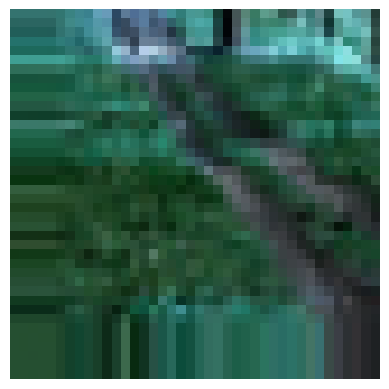

In [11]:
non_target = []
IMAGE_SIZE = (40, 40)

for img in non_df['filename']:
    img = cv.imread('notbtterfly/' + img)
    img = cv.resize(img, IMAGE_SIZE)
    non_target.append(img/255.0)

from tensorflow.keras.preprocessing.image import ImageDataGenerator


datagen = ImageDataGenerator(
    rotation_range=30,  # Rotate images by 30 degrees @ random
    width_shift_range=0.2,  # Shift images horizontally 20% of total width @ random
    height_shift_range=0.2,  # Shift images vertically 20% of total height @ random
    shear_range=0.3,  # Apply shear transformation with a shear angle of 30 degrees
    zoom_range=0.3,  # Zoom images by up to 30% @ random
    horizontal_flip=True,  # Flip images horizontally @ random
    vertical_flip=False  # Do not perform vertical flips
)

# grayscale numpy array of images 
images = non_target 

# Generate augmented grayscale images
augmented_images = []

for image in images:
    num_generated_images = 0

    while num_generated_images < 60:
        augmented_image = datagen.random_transform(image)
        augmented_images.append(augmented_image)
        num_generated_images += 1

# Convert augmented grayscale images back to a NumPy array
augmented_images = np.array(augmented_images)
non_target = np.squeeze(augmented_images)
print(non_target.shape)
plt.imshow(non_target[0])
plt.axis('off')
plt.show()


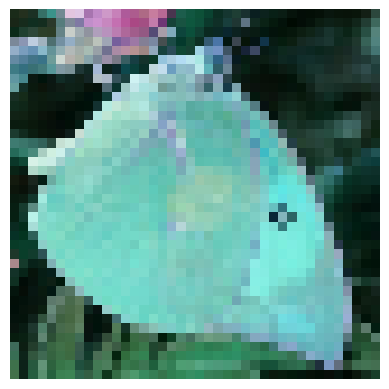

In [12]:
IMAGE_SIZE = (40,40)
IMAGE_SIZE_CLASS = (60,60)

train = []

train_class = []
train_labels = []

test = []

for img,label in zip(df_train['filename'], df_train['label_en']):
    img = cv.imread('train/'+img)
    det = cv.resize(img, IMAGE_SIZE)
    clas = cv.resize(img, IMAGE_SIZE_CLASS)
    train.append(det/255.0)
    train_class.append(clas/255.0)
    train_labels.append(label)

for img in df_test['filename']:
    img = cv.imread('test/' + img)
    img = cv.resize(img, IMAGE_SIZE)
    test.append(img/255.0)

plt.imshow(train[0])
plt.axis('off')
plt.show()

In [13]:
images = list(train)+list(test)

# Generate augmented images
augmented_images_target = []
for image in images:
    num_generated_images = 0

    while num_generated_images < 6:
        augmented_image = datagen.random_transform(image)
        augmented_images_target.append(augmented_image)
        num_generated_images += 1

augmented_images_target = np.array(augmented_images_target)
target = np.squeeze(augmented_images_target)
print(target.shape)

(55710, 40, 40, 3)


In [14]:
X = np.array(list(target)+ list(non_target))
Y = np.array([1]*len(target)+[0]*len(list(non_target)))

X.shape, Y.shape

((236910, 40, 40, 3), (236910,))

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify=Y)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((177682, 40, 40, 3), (59228, 40, 40, 3), (177682,), (59228,))

In [16]:
import tensorflow as tf
from tensorflow import keras

In [17]:
# Define the CNN model
model = keras.Sequential()
model.add(keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(40, 40, 3)))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, Y_train, epochs=20, batch_size=64)

model.summary()

Epoch 1/20
2777/2777 [==============================] - 63s 22ms/step - loss: 0.1427 - accuracy: 0.9453
Epoch 2/20
2777/2777 [==============================] - 66s 24ms/step - loss: 0.0848 - accuracy: 0.9686
Epoch 3/20
2777/2777 [==============================] - 74s 27ms/step - loss: 0.0680 - accuracy: 0.9748
Epoch 4/20
2777/2777 [==============================] - 66s 24ms/step - loss: 0.0543 - accuracy: 0.9801
Epoch 5/20
2777/2777 [==============================] - 63s 23ms/step - loss: 0.0440 - accuracy: 0.9839
Epoch 6/20
2777/2777 [==============================] - 65s 23ms/step - loss: 0.0368 - accuracy: 0.9867
Epoch 7/20
2777/2777 [==============================] - 65s 24ms/step - loss: 0.0291 - accuracy: 0.9895
Epoch 8/20
2777/2777 [==============================] - 64s 23ms/step - loss: 0.0243 - accuracy: 0.9914
Epoch 9/20
2777/2777 [==============================] - 64s 23ms/step - loss: 0.0196 - accuracy: 0.9930
Epoch 10/20
2777/2777 [==============================] - 64s 23m

<div>
    <h2 style = "font-size: 24px; color: #FFC0CB; text-align: center;" > Detection Model Evaluation  </h2>
    <h3 style = "font-size: 12px; color: #9370DB; text-aligh: center;"	> I learned the hardway that this will fail if you have too many google chrome tabs open.  </h3>

</div>

In [18]:
model.evaluate(X_test, Y_test)

1851/1851 [==============================] - 8s 4ms/step - loss: 0.0761 - accuracy: 0.9842


[0.07614270597696304, 0.9842135310173035]

In [19]:
tensors = tf.convert_to_tensor(np.array(X_test))
probabilities = model.predict(tensors)
threshold = 0.3
Y_pred = (probabilities > threshold).astype(int)[:,0]
Y_pred

1851/1851 [==============================] - 8s 4ms/step


array([0, 0, 0, ..., 0, 0, 0])

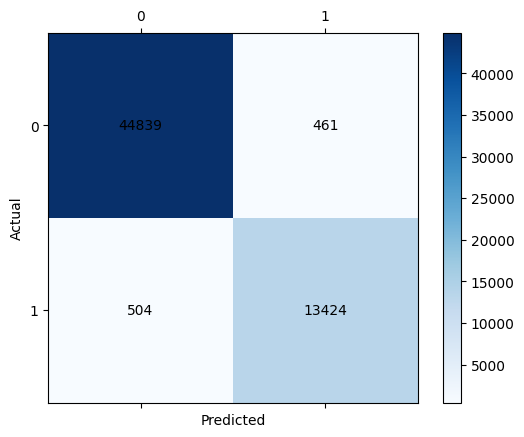

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

cm = confusion_matrix(Y_test, Y_pred)

fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
plt.colorbar(cax)

classes = np.unique(Y_test)
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center')

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [21]:
cr = classification_report(Y_test, Y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     45300
           1       0.97      0.96      0.97     13928

    accuracy                           0.98     59228
   macro avg       0.98      0.98      0.98     59228
weighted avg       0.98      0.98      0.98     59228



<div>
    <h2 style = "font-size: 24px; color: #FFC0CB; text-align: center;" > Work Cited  </h2>
    <style>
        ul li{
            color: ##8B008B;
            padding: 5px;
        }
     </style> 
     <body>  
        <ul>
            <li>https://www.youtube.com/playlist?list=PLIRnO_sdVuEfau_eJKVhiaLaqIXCT0F-_ </li>
            <li> https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator</li>
            <li> https://www.youtube.com/watch?v=PW9_cK8PR5E </li>
            <li> https://www.kaggle.com/datasets/phucthaiv02/butterfly-image-classification </li>
            <li> https://www.kaggle.com/datasets/pankajkumar2002/random-image-sample-dataset/ </li>
         </ul>

</div>
</body>